Just out of curiousity, we will see if downscaling full domain is achievable in reasonable time. 

In [40]:
# config cell
import warnings
from pathlib import Path
import cftime
import dask
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from pyproj import Proj
from xclim import units, sdba, indices
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import hvplot.xarray
import panel as pn

pn.extension(comms="vscode")
# for reloading the baeda module which is actively developing
import baeda
from importlib import reload


cutoff_time = cftime.DatetimeNoLeap(2015, 1, 1, 0, 0, 0, 0, 0)

# zarr_dir = Path("/beegfs/CMIP6/kmredilla/zarr_bias_adjust_inputs/zarr")
zarr_dir = Path("/center1/CMIP6/kmredilla/zarr_bias_adjust_inputs")

# era5_dir = Path("/beegfs/CMIP6/kmredilla/era5_3338_zarr/zarr")
era5_dir = Path("/center1/CMIP6/kmredilla/era5_zarr")

# tmp dir for writing downscaled data
tmp_target_dir = Path("/beegfs/CMIP6/kmredilla/downscaling/eda")
# template filename for downscaled outputs
tmp_fn = "{qm}_{var_id}_{model}_{scenario}.zarr"


# models and scenarios to test
models = ["GFDL-ESM4"]
scenarios = ["ssp245"]
var_ids = ["tasmax", "pr"]

dask.config.set({"large-graph-warning-threshold": "100MB"})


index_name_lu = {
    "pr": {
        "rx1day": "Max 1-day precip",
        "rx5day": "Max 5-day precip",
        "cdd": "Consecutive dry Days",
        "cwd": "Consecutive wet days",
    }
}

# Processing

This section is for running the downscaling and computing indicators. It saves the output to a temporary directory and so need not be run if outputs for the visualization section already exist. 

In [123]:
# client = Client(n_workers=12, threads_per_worker=2)

# for interactive nb testing
cluster = SLURMCluster(
    cores=28,
    processes=14,
    # n_workers=14,
    memory="128GB",
    # queue="debug",
    queue="t2small",
    # walltime="01:00:00",
    walltime="12:00:00",
    log_directory=".",
    account="cmip6",
    interface="ib0",
)
client = Client(cluster)

cluster.scale(n=56)

In [5]:
# connect to ERA5 data
era5_stores = {
    "t2max": era5_dir.joinpath("t2max_era5.zarr"),
    "pr": era5_dir.joinpath("pr_era5.zarr"),
}

era5_ds = baeda.open_era5_dataset(era5_stores)

In [6]:
# connect to regridded GCM data
model = "GFDL-ESM4"
scenario = "ssp245"
var_id = "pr"

hist, sim = baeda.extract_time_series_from_zarr(
    zarr_dir, model, scenario, var_id, coords=None
)

In [7]:
# QDM: train the adjustment
chunk_kwargs = {"time": -1, "x": 10, "y": 10}
train_kwargs = dict(
    ref=era5_ds[var_id].chunk(**chunk_kwargs),
    # think having experiment coordinate may quietly prevent
    # adjustment of data with different coordinates (e.g. ssp's)
    hist=hist.chunk(**chunk_kwargs)
    .isel(Method=0, experiment=0)
    .drop_vars(["Method", "experiment"]),
    nquantiles=50,
    group="time.dayofyear",
    window=31,
    kind=baeda.varid_adj_kind_lu[var_id],
)
if var_id in baeda.adapt_freq_thresh_lu:
    train_kwargs.update(
        adapt_freq_thresh=baeda.adapt_freq_thresh_lu[var_id],
        jitter_under_thresh_value=baeda.jitter_under_thresh_lu[var_id],
    )

# dqm_train = sdba.DetrendedQuantileMapping.train(**train_kwargs)
qdm_train = sdba.QuantileDeltaMapping.train(**train_kwargs)

In [8]:
# run the QDM adjustment for historical
qm_method = "QDM"
hist_adj = (
    qdm_train.adjust(
        hist.chunk(**chunk_kwargs),
        extrapolation="constant",
        interp="nearest",
    )
    .isel(Method=0, drop=True)
    .assign_coords(Method=qm_method)
    .expand_dims("Method")
    .transpose("Method", "experiment", "time", "y", "x")
)
hist_adj.name = var_id

# compute
hist_adj = hist_adj.load()

# write
out_fp = tmp_target_dir.joinpath(
    tmp_fn.format(
        qm=qm_method.lower(), var_id=var_id, model=model, scenario="historical"
    )
)
hist_adj.to_dataset().to_zarr(out_fp)

In [34]:
# run the QDM adjustment for scenario
qm_method = "QDM"
sim_adj = (
    qdm_train.adjust(
        sim.chunk(**chunk_kwargs),
        extrapolation="constant",
        interp="nearest",
    )
    .isel(Method=0, drop=True)
    .assign_coords(Method=qm_method)
    .expand_dims("Method")
    .transpose("Method", "experiment", "time", "y", "x")
)
sim_adj.name = var_id

# compute
sim_adj = sim_adj.load()

# write
out_fp = tmp_target_dir.joinpath(
    tmp_fn.format(qm=qm_method.lower(), var_id=var_id, model=model, scenario=scenario)
)
sim_adj.to_dataset().to_zarr(out_fp)

In [ ]:
# template code for DQM configs

# adj_das = []
# for det_name, det in baeda.detrend_configs.items():
#     scen = dqm_train.adjust(
#         sim,
#         extrapolation="constant",
#         interp="nearest",
#         detrend=det,
#     )
#     adj_das.append(scen)

# # run the QDM adjustment
# qdm_da = qdm_train.adjust(
#     sim,
#     extrapolation="constant",
#     interp="nearest",
# )
# adj_das.append(qdm_da)

# # combine the DQM and QDM data
# adj_da = xr.concat(adj_das, dim="Method").rename(sim.name)
# adj_da["Method"] = list(detrend_configs.keys()) + ["QDM"]
# adj_da = adj_da

In [ ]:
# run historical indicators
hist_idx = baeda.run_indicators(hist_adj)
out_fp = tmp_target_dir.joinpath(
    tmp_fn.format(
        qm=qm_method.lower(), var_id=var_id + "idx", model=model, scenario="historical"
    )
)
hist_idx.to_zarr(out_fp)

In [99]:
# run projected indicators
sim_idx = baeda.run_indicators(sim_adj)
out_fp = tmp_target_dir.joinpath(
    tmp_fn.format(
        qm=qm_method.lower(), var_id=var_id + "idx", model=model, scenario=scenario
    )
)
sim_idx.to_zarr(out_fp)

In [132]:
era5_idx = baeda.run_indicators(era5_ds[var_id])
out_fp = tmp_target_dir.joinpath(f"{var_id + 'idx'}_era5.zarr")
era5_idx.to_zarr(out_fp)

/home/kmredilla/miniconda3/envs/cmip6-utils/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 67.34 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


# Visualization

In [2]:
model = "GFDL-ESM4"
scenario = "ssp245"
var_id = "pr"
qm_method = "QDM"


client = Client()


# connect to ERA5 data
era5_stores = {
    "t2max": era5_dir.joinpath("t2max_era5.zarr"),
    "pr": era5_dir.joinpath("pr_era5.zarr"),
}
era5_ds = baeda.open_era5_dataset(era5_stores)

# adjusted GCM data
hist_adj_fp = tmp_target_dir.joinpath(
    tmp_fn.format(
        qm=qm_method.lower(), var_id=var_id, model=model, scenario="historical"
    )
)
hist_adj = xr.open_zarr(hist_adj_fp)

sim_adj_fp = tmp_target_dir.joinpath(
    tmp_fn.format(qm=qm_method.lower(), var_id=var_id, model=model, scenario=scenario)
)
sim_adj = xr.open_zarr(sim_adj_fp)


# indicators
era5_idx_fp = tmp_target_dir.joinpath(f"{var_id + 'idx'}_era5.zarr")
era5_idx = xr.open_zarr(era5_idx_fp)

sim_idx_fp = tmp_target_dir.joinpath(
    tmp_fn.format(
        qm=qm_method.lower(), var_id=var_id + "idx", model=model, scenario=scenario
    )
)
sim_idx = xr.open_zarr(sim_idx_fp)

hist_idx_fp = tmp_target_dir.joinpath(
    tmp_fn.format(
        qm=qm_method.lower(), var_id=var_id + "idx", model=model, scenario="historical"
    )
)
hist_idx = xr.open_zarr(hist_idx_fp)

## Deltas

### Monthly climatology deltas, $Downscaled - ERA5$

In [3]:
deltas = (
    hist_adj[var_id].groupby("time.month").mean()
    - era5_ds[var_id].groupby("time.month").mean()
)
deltas = deltas.load()

/home/kmredilla/miniconda3/envs/cmip6-utils/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 26.59 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [20]:
w_month = pn.widgets.IntSlider(name="Month", start=1, end=12)

# deltas_da.interactive.isel(Method=0, experiment=0, month=w_month).hvplot()#.opts(width=800, height=500)
deltas.isel(Method=0, experiment=0, drop=True).interactive.sel(month=w_month).hvplot(
    cmap="BrBG", kind="image", clabel=hist_adj[var_id].attrs["units"]
).opts(width=800, height=500)

BokehModel(combine_events=True, render_bundle={'docs_json': {'781f6f0c-afa9-4717-8fec-ae9ed1de9c73': {'version…

## Indicators

In [24]:
# just loading the indicators for quick computes
hist_idx = hist_idx.load()
era5_idx = era5_idx.load()
sim_idx = sim_idx.load()

### Indicator climatology deltas ($Downscaled - ERA5$)

In [ ]:
mean_idx_deltas = (hist_idx.mean(dim="time") - era5_idx.mean(dim="time")).isel(
    Method=0, experiment=0, drop=True
)
idx_sel = pn.widgets.Select(
    options={index_name_lu[var_id][v]: v for v in mean_idx_deltas.data_vars}
)
pn.Column(
    idx_sel, mean_idx_deltas.hvplot.image(z=idx_sel, cmap="BrBG", width=800, height=500)
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'abe16920-dcff-414c-9c20-511fb335c2bf': {'version…

In [ ]:
tmp_da = hist_idx.mean(dim="time").isel(Method=0, experiment=0, drop=True)
idx_sel = pn.widgets.Select(
    options={index_name_lu[var_id][v]: v for v in mean_idx_deltas.data_vars}
)
pn.Column(idx_sel, tmp_da.hvplot.image(z=idx_sel, cmap="BrBG", width=800, height=500))

BokehModel(combine_events=True, render_bundle={'docs_json': {'2365e877-ea69-48af-a356-7b2472b1c6ee': {'version…

In [47]:
tmp_da = era5_idx.mean(dim="time")
idx_sel = pn.widgets.Select(
    options={index_name_lu[var_id][v]: v for v in mean_idx_deltas.data_vars}
)
pn.Column(idx_sel, tmp_da.hvplot.image(z=idx_sel, cmap="BrBG", width=800, height=500))

BokehModel(combine_events=True, render_bundle={'docs_json': {'6e641677-c422-44eb-94fa-c32a87730edd': {'version…

In [51]:
# connect to regridded GCM data
model = "GFDL-ESM4"
scenario = "ssp245"
var_id = "pr"

hist, sim = baeda.extract_time_series_from_zarr(
    zarr_dir, model, scenario, var_id, coords=None
)

In [ ]:
# wanna compare CDFs of ERA5 and GCM at this point
x = 4.839e5
y = 1.265e6

era5_extr = (
    era5_ds[var_id]
    .sel(x=x, y=y, method="nearest", drop=True)
    .assign_coords(Method="ERA5")
)
hist_extr = hist.sel(x=x, y=y, method="nearest", drop=True).isel(
    experiment=0, drop=True
)
hist_adj_extr = hist_adj.sel(x=x, y=y, method="nearest", drop=True).isel(
    experiment=0, drop=True
)

In [ ]:
df = pd.concat(
    [
        hist_extr.to_dataframe().reset_index(),
        era5_extr.to_dataframe().reset_index(),
        hist_adj_extr.to_dataframe().reset_index(),
    ]
)

<Axes: xlabel='pr', ylabel='Proportion'>

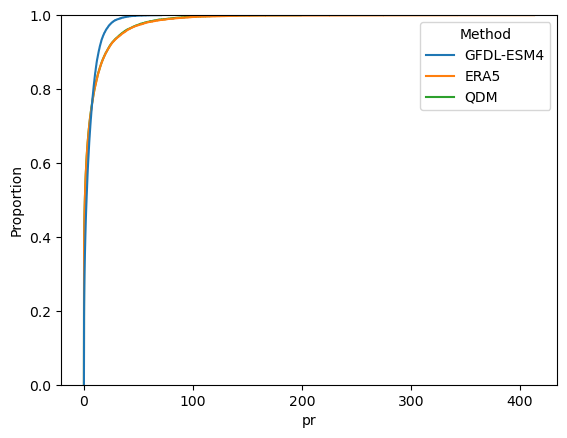

In [ ]:
sns.ecdfplot(df, x="pr", hue="Method")

<Axes: xlabel='pr', ylabel='Proportion'>

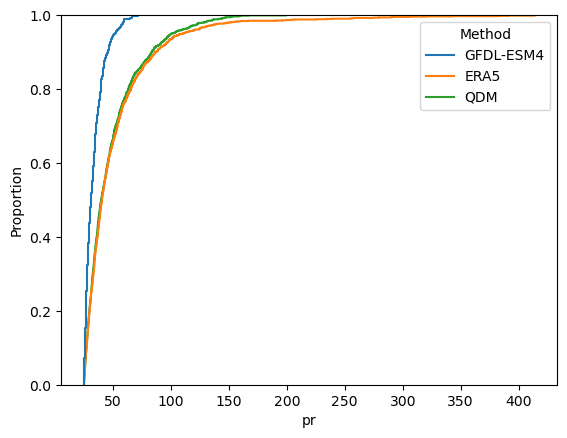

In [ ]:
sns.ecdfplot(df.query("pr > 25"), x="pr", hue="Method")

In [89]:
hist_extr.max()

<xarray.DataArray 'pr' ()> Size: 8B
array(71.49914551)

In [108]:
hist_extr.where(hist_extr == hist_extr.max(), drop=True)

<xarray.DataArray 'pr' (Method: 1, time: 1)> Size: 4B
array([[71.499146]], dtype=float32)
Coordinates:
  * time     (time) object 8B 1970-09-27 00:00:00
  * Method   (Method) <U9 36B 'GFDL-ESM4'
Attributes:
    units:          mm d-1
    standard_name:  lwe_precipitation_rate
    source_id:      GFDL-ESM4
    experiment_id:  historical

In [ ]:
prmax_doy = hist_extr.where(
    hist_extr == hist_extr.max(), drop=True
).time.dt.dayofyear.item()

In [97]:
doys = list(range(prmax_doy - 15, prmax_doy)) + list(range(prmax_doy, prmax_doy + 15))

In [ ]:
window_df = pd.concat(
    [
        hist_extr.sel(time=hist_extr.time.dt.dayofyear.isin(doys))
        .to_dataframe()
        .reset_index(),
        era5_extr.sel(time=era5_extr.time.dt.dayofyear.isin(doys))
        .assign_coords(Method="ERA5")
        .to_dataframe()
        .reset_index(),
        hist_adj_extr.sel(time=hist_adj_extr.time.dt.dayofyear.isin(doys))
        .to_dataframe()
        .reset_index(),
    ]
)

<Axes: xlabel='pr', ylabel='Proportion'>

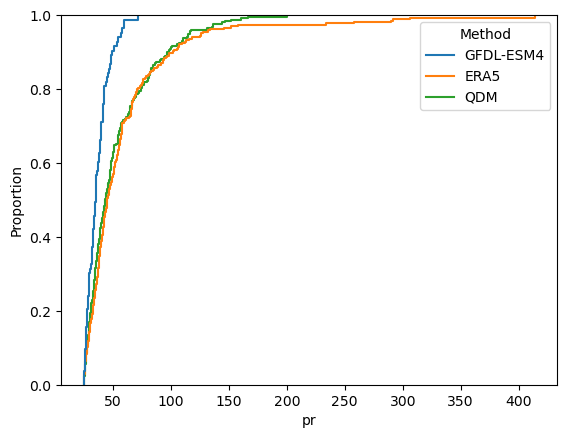

In [ ]:
sns.ecdfplot(window_df.query("pr > 25"), x="pr", hue="Method")